# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
import numpy as np
from IPython.display import HTML, SVG, display
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
import pydot

from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.systems.planar_scenegraph_visualizer import ConnectPlanarSceneGraphVisualizer
from pydrake.systems.primitives import LogVectorOutput, WrapToSystem
from pydrake.all import StartMeshcat, MeshcatVisualizer, MeshcatVisualizerParams

In [2]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Compute the end effector (the ball) position and velocity using symbolic variables

This is how we get the expression in `kinematic_constraints.py`

In [3]:
# Computes the end effector velocity as xdot, ydot J_q (pos) * qdot

from sympy import *
import numpy as np

l, q0, q1, qdot0, qdot1 = symbols('l q0 q1 qdot0 qdot1', real=True)
pos = l * Matrix([-sin(q0), -cos(q0)]) + \
      l * Matrix([-sin(q0 + q1), -cos(q0 + q1)])
vel = Matrix(pos).jacobian([q0, q1]) @ np.reshape(np.array([qdot0, qdot1]), (2,1))

print('pos (x_ball, z_ball):\n', pos)
print('')
print('vel (x_ball dot, z_ball dot):\n', vel)

pos (x_ball, z_ball):
 Matrix([[-l*sin(q0) - l*sin(q0 + q1)], [-l*cos(q0) - l*cos(q0 + q1)]])

vel (x_ball dot, z_ball dot):
 Matrix([[-l*qdot1*cos(q0 + q1) + qdot0*(-l*cos(q0) - l*cos(q0 + q1))], [l*qdot1*sin(q0 + q1) + qdot0*(l*sin(q0) + l*sin(q0 + q1))]])


## Set up Ball Trajectory

The ball is in the air for 0.6992906373179558s


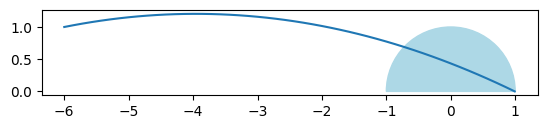

In [4]:
from matplotlib.patches import Wedge

g = 9.81

def CalcCatchPos(q0, v0, t_catch):
    y_final = q0[1] + v0[1] * t_catch
    x_final = q0[0] + v0[0] * t_catch
    z_final = q0[2] + v0[2] * t_catch - 0.5 * g * t_catch**2
    return np.array([x_final, y_final, z_final])

def tFall(q0, v0):
    # Solve 0 = q0[2] + v0[2] * t - 0.5 * g * t**2
    a = -0.5 * g
    b = v0[2]
    c = q0[2]
    return (-b - np.sqrt(b*b - 4*a*c)) / (2*a)

q0_ball = np.array([-6, 0, 1])
v0_ball = np.array([10, 1, 2])

max_t = tFall(q0_ball, v0_ball)
print(f'The ball is in the air for {max_t}s')
plot_t = np.linspace(0, max_t, 50)
plot_q = np.array([CalcCatchPos(q0_ball, v0_ball, t) for t in plot_t])

fig, ax = plt.subplots()
plt.gca().set_aspect('equal')
ax.plot(plot_q[:,0], plot_q[:,2])
# ax.add_patch(plt.Circle((0,0), 1, color='lightblue'))
ax.add_patch(Wedge((0,0), 1, 0, 180, color='lightblue'))
plt.show()

## Run trajectory optimization to find the optimal trajectory

In [5]:
import importlib
import catching_trajectory
importlib.reload(catching_trajectory)
from catching_trajectory import find_throwing_trajectory

N = 15
initial_state = [0, 0, 0, -0.5, 0, 0, 0] + [0] * 7
final_configuration = np.array([np.pi, 0])
tf = 1
distance = 15.0

x_traj, u_traj, t_catch, prog, _, _ = find_throwing_trajectory(N, q0_ball, v0_ball, initial_state, final_configuration, distance)


n_q =  7
n_v =  7
n_x =  14
n_u =  7
[87. 87. 87. 87. 12. 12. 12.]
[2.175 2.175 2.175 2.175 2.61  2.61  2.61 ]
pos cur = 
 [[ 1.00000000e+00  8.76127349e-11 -7.96607865e-11  2.00000000e-01]
 [ 8.76126883e-11 -1.00000000e+00  2.34955237e-11  1.26829176e-12]
 [-7.96608085e-11 -2.34955204e-11 -1.00000000e+00  8.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Solution is valid
Solver is  SNOPT
optimal cost:  6281.673592665532
x_sol:  [[-1.31253845e-13  6.75340897e-17  3.60601610e-15 -5.00000000e-01
   2.81330396e-14 -8.02592728e-14  1.37974738e-14  1.44718818e-13
   6.04184716e-14  1.86525602e-15 -1.48412189e-13  1.89139094e-14
   4.85593388e-14  4.59654495e-14]
 [ 1.04018420e-02  7.97571521e-04  1.67951931e-02 -5.05745218e-01
   1.10026282e-02  1.61268091e-02 -3.00850936e-04  4.93634025e-01
   4.18752771e-02  7.94748820e-01 -2.78424749e-01  5.20479893e-01
   7.69783662e-01 -1.56432389e-02]
 [ 3.95709404e-02  3.96323773e-03  6.33789790e-02 -5.22894460e-01


## Validate the Solution

In [6]:
def create_ee_query():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
    Parser(plant).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
    plant.Finalize()
    context = plant.CreateDefaultContext()
    ee_frame = plant.GetBodyByName("panda_link8").body_frame()
    def query(state):
        context.SetContinuousState(state)
        return plant.CalcPointsPositions(context, ee_frame, np.zeros(3), plant.world_frame()).ravel()
    return query

print('Ball Position', CalcCatchPos(q0_ball, v0_ball, t_catch).ravel())
np.set_printoptions(suppress=True)
print('EE Position', create_ee_query()(x_traj.value(t_catch)))

Ball Position [0.1856058  0.61856058 0.36038384]
EE Position [0.1856058  0.61856058 0.36038384]


## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph
)


# Create a MultibodyPlant for the arm
# file_name = "planar_arm.urdf"
builder = DiagramBuilder()
ball, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
# scene_graph = builder.AddSystem(SceneGraph())
planar_arm = builder.AddSystem(MultibodyPlant(0.0))
# planar_arm, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
planar_arm.RegisterAsSourceForSceneGraph(scene_graph)
# Parser(plant=planar_arm).AddModels(file_name)
Parser(plant=planar_arm).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
planar_arm.WeldFrames(planar_arm.world_frame(), planar_arm.GetFrameByName("panda_link0"))
planar_arm.Finalize()

# ball = builder.AddSystem(MultibodyPlant(0.0))
Parser(plant=ball).AddModels("./ball.urdf")
ball.Finalize()
# ball.RegisterAsSourceForSceneGraph(scene_graph)
# builder.Connect(ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(ball.get_source_id()))
# builder.Connect(scene_graph.get_query_output_port(), ball.get_geometry_query_input_port())

n_q = planar_arm.num_positions()
n_v = planar_arm.num_velocities()
n_u = planar_arm.num_actuators()

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(planar_arm))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), planar_arm.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(planar_arm.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), planar_arm.get_geometry_query_input_port())

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the motion for `n_playback` times
n_playback = 3
for i in range(n_playback):
  # Set up a simulator to run this diagram.
    context = diagram.CreateDefaultContext()
    ball.SetPositions(ball.GetMyContextFromRoot(context), [0, 0, 0, 1, *q0_ball])
    ball.SetVelocities(ball.GetMyContextFromRoot(context), [0, 0, 0, *v0_ball])
    simulator = Simulator(diagram, context)
    simulator.Initialize()
    time.sleep(1)
    simulator.set_target_realtime_rate(0.2)
    simulator.AdvanceTo(t_catch);
    time.sleep(1)

## Naive Control

In [8]:
from pydrake.all import LogVectorOutput

def arm_sim(time, initial_state, log=False, visualize=False, graph=False, meshcat=None, control=None,
            accuracy=1e-4, min_step=0, step_target=None, fixed_step=False):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
    parser = Parser(plant)
    parser.AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
    plant.Finalize()

    ball = builder.AddSystem(MultibodyPlant(0.0))
    ball.RegisterAsSourceForSceneGraph(scene_graph)
    builder.Connect(ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(ball.get_source_id()))
    builder.Connect(scene_graph.get_query_output_port(), ball.get_geometry_query_input_port())
    ball.set_name("ball")
    Parser(plant=ball).AddModels("./ball.urdf")
    ball.Finalize()
    
    # ball = AddMultibodyPlantSceneGraph(builder, 0, scene_graph)
    # Parser(plant=ball).AddModels("./ball.urdf")
    # ball.Finalize()
    
    n_pos = plant.num_positions()

    if log:
        logger = LogVectorOutput(plant.get_state_output_port(), builder)
    if meshcat:
        vis_params = MeshcatVisualizerParams(publish_period=0.01)
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
    if visualize:
        T_VW = np.array([[1., 0., 0., 0.],
                         [0., 0., 1., 0.],
                         [0., 0., 0., 1.]])
        visualizer = ConnectPlanarSceneGraphVisualizer(
            builder, scene_graph, T_VW=T_VW, xlim=[-1, 1],
            ylim=[-0.2, 1.5], show=False)
    if control:
        controller = builder.AddSystem(control(plant))
        # builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
        # builder.Connect(plant.get_body_poses_output_port(), controller.get_input_port(1))
        # builder.Connect(plant.get_body_spatial_velocities_output_port(), controller.get_input_port(2))
        builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())

    diagram = builder.Build()
    if graph:
        display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    context = diagram.CreateDefaultContext()
    simulator = Simulator(diagram, context)
    simulator.get_integrator().set_target_accuracy(accuracy)
    if step_target is not None:
        simulator.get_integrator().request_initial_step_size_target(step_target)
    simulator.get_integrator().set_requested_minimum_step_size(min_step)
    simulator.get_integrator().set_fixed_step_mode(fixed_step)
    simulator.Initialize()
    plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
    if control:
        controller.plant_context = plant_context
    else:
        plant.get_actuation_input_port().FixValue(plant_context, np.zeros(plant.num_actuators()))
    if meshcat:
        simulator.set_target_realtime_rate(1)
    plant.SetPositionsAndVelocities(plant.GetMyContextFromRoot(context), initial_state)
    ball.SetPositions(ball.GetMyContextFromRoot(context), [0, 0, 0, 1, *q0_ball])
    ball.SetVelocities(ball.GetMyContextFromRoot(context), [0, 0, 0, *v0_ball])
    if visualize:
        visualizer.start_recording()

    for t in tqdm(np.linspace(0, time, 100), file=sys.stdout):
        simulator.AdvanceTo(t)

    if log:
        log = logger.FindLog(context)
        time = log.sample_times()[1:]
        data = log.data()[:,1:]
    if visualize:
        visualizer.stop_recording()
        ani = HTML(visualizer.get_recording_as_animation().to_jshtml())
    if log and visualize:
        return time, data, ani
    if log:
        return time, data
    if visualize:
        return ani

In [9]:
from pydrake.all import LeafSystem, ConnectPlanarSceneGraphVisualizer, MeshcatVisualizerParams
from tqdm import tqdm
import sys
from IPython.display import HTML, SVG, display

class ExecuteTraj(LeafSystem):
    def __init__(self, plant, u_traj):
        LeafSystem.__init__(self)
        self.u_traj = u_traj
        self.DeclareVectorOutputPort("input", plant.num_actuators(), self.CalcOutput)
        
    def CalcOutput(self, context, output):
        u = self.u_traj.value(context.get_time())
        output.SetFromVector(u)

c = lambda plant: ExecuteTraj(plant, u_traj)
arm_sim(t_catch, initial_state, meshcat=meshcat, graph=False, control=c)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 193.97it/s]


Result: the robot spins around a lot, and doesn't go at all where we want it to go.

## Operation Space Control

In [97]:
from pydrake.all import JacobianWrtVariable, MathematicalProgram, Solve

def wrap_angle(a):
    if a > np.pi:
        return a - 2*np.pi
    if a < -np.pi:
        return a + 2*np.pi
    return a
def wrap_angles(v):
    return np.array([wrap_angle(a) for a in v])

class OSC(LeafSystem):
    def __init__(self, plant, xtraj, Kp, Dp, Ka, Da, feedforward, frequency):
        LeafSystem.__init__(self)
        self.plant = plant
        self._ee_body = self.plant.GetBodyByName("panda_link8")
        self._ee_index = self._ee_body.index()
        self._ee_frame = self._ee_body.body_frame()

        self.DeclareVectorOutputPort("input", plant.num_actuators(), self.CalcOutput)
        self.Kp = Kp
        self.Dp = Dp
        self.Ka = Ka
        self.Da = Da
        self.xtraj = xtraj
        self.feedforward = feedforward
        self.frequency = frequency
        self.step = -1

    def CalcFeedForward(self, x_des, a):
        ctx = self.plant.CreateDefaultContext()
        self.plant.SetPositionsAndVelocities(ctx, x_des)
        J_ee = self.plant.CalcJacobianTranslationalVelocity(ctx,
                                                            JacobianWrtVariable.kV,
                                                            self._ee_frame,
                                                            np.array([0, 0,0]),
                                                            self.plant.world_frame(),
                                                            self.plant.world_frame())
        Jdot_ee_v = self.plant.CalcBiasTranslationalAcceleration(ctx,
                                                            JacobianWrtVariable.kV,
                                                            self._ee_frame,
                                                            np.array([0, 0,0]),
                                                            self.plant.world_frame(),
                                                            self.plant.world_frame()).ravel()
        return J_ee @ a + Jdot_ee_v
        
    def CalcOutput(self, context, output):
        if self.frequency is not None:
            step = np.floor(context.get_time() * self.frequency)
            if step <= self.step:
                output.SetFromVector(self.u)
                return
            self.step = step
        
        J_ee = self.plant.CalcJacobianTranslationalVelocity(self.plant_context,
                                                            JacobianWrtVariable.kV,
                                                            self._ee_frame,
                                                            np.array([0, 0,0]),
                                                            self.plant.world_frame(),
                                                            self.plant.world_frame())
        Ja_ee = self.plant.CalcJacobianAngularVelocity(self.plant_context,
                                                       JacobianWrtVariable.kV,
                                                       self._ee_frame,
                                                       self.plant.world_frame(),
                                                       self.plant.world_frame())
        Jdot_ee_v = self.plant.CalcBiasTranslationalAcceleration(self.plant_context,
                                                            JacobianWrtVariable.kV,
                                                            self._ee_frame,
                                                            np.array([0, 0,0]),
                                                            self.plant.world_frame(),
                                                            self.plant.world_frame()).ravel()

        x_des = self.xtraj.value(context.get_time())
        q = x_des[:self.plant.num_positions()].ravel()
        v = x_des[self.plant.num_positions():].ravel()
        a = self.xtraj.derivative().value(context.get_time())[self.plant.num_positions():].ravel()

        ctx = self.plant.CreateDefaultContext()
        ctx.SetContinuousState(x_des.ravel())
        x_ee_des = self.plant.CalcPointsPositions(ctx, self._ee_frame,
                                              np.array([0, 0,0]), self.plant.world_frame()).ravel()
        xdot_ee_des = J_ee @ v

        x_ee = self.plant.CalcPointsPositions(self.plant_context, self._ee_frame,
                                              np.array([0, 0,0]), self.plant.world_frame()).ravel()

        # ee_pose = self.plant.EvalBodyPoseInWorld(self.plant_context, self._ee_body)
        # ee_quat = ee_pose.rotation().ToQuaternion()
        # ee_R = R.from_quat([ee_quat.x(), ee_quat.y(), ee_quat.z(), ee_quat.w()])
        # ee_XYZ = ee_R.as_euler('XYZ')
        
        xdot_ee = (J_ee @ self.plant.GetVelocities(self.plant_context)).ravel()
        
        # ee_XYZdot = (Ja_ee @ self.plant.GetVelocities(self.plant_context)).ravel()
        
        
        M = self.plant.CalcMassMatrix(self.plant_context)
        Cv = self.plant.CalcBiasTerm(self.plant_context)
        G = -self.plant.CalcGravityGeneralizedForces(self.plant_context) # Negated to match our notation
        B = self.plant.MakeActuationMatrix()

        prog = MathematicalProgram()
        W_i = np.eye(J_ee.shape[0])

        u = prog.NewContinuousVariables(self.plant.num_actuators(), "u")
        vdot = prog.NewContinuousVariables(self.plant.num_velocities(), "vdot")

        xddot_ee_des = self.Kp*(x_ee_des - x_ee) + self.Dp*(xdot_ee_des - xdot_ee)
        if self.feedforward:
            xddot_ee_des += self.CalcFeedForward(x_des, a)
        # print(x_ee, x_ee_des, xddot_ee_des)

        # xaddot_ee_des = self.Ka*wrap_angles(np.array([0, np.pi/2, 0]) - ee_XYZ) + self.Da*(0 - ee_XYZdot)
        # xaddot_ee_des = 10  - ee_XYZ) - 5*ee_XYZdot

        # cost = (- J_ee @ vdot).T @ W_i @ (- J_ee @ vdot)
        # prog.AddQuadraticCost(cost)
        W_i = np.diag([1, 1, 1])
        W_a = np.diag([1, 1, 1])
        # print(J_ee.T @ W_i @ J_ee)
        # print(np.linalg.eig(J_ee.T @ W_i @ J_ee))

        w_vdot = np.eye(7) * 0.1
        prog.AddQuadraticCost(vdot.T @ w_vdot @ vdot)

        # Position
        prog.AddQuadraticCost(2*J_ee.T @ W_i @ J_ee,
                              -2*(xddot_ee_des - Jdot_ee_v).T @ W_i @ J_ee,
                              (xddot_ee_des - Jdot_ee_v).T @ W_i @ (xddot_ee_des - Jdot_ee_v),
                              vdot)

        # Angle
        # prog.AddQuadraticCost(2*Ja_ee.T @ W_a @ Ja_ee,
        #                       -2*(xaddot_ee_des - 0).T @ W_a @ Ja_ee,
        #                       (xaddot_ee_des - 0).T @ W_a @ (xaddot_ee_des - 0),
        #                       vdot)
        
        prog.AddLinearEqualityConstraint(M @ vdot + Cv + G - B @ u, np.zeros(G.shape[0]))
        prog.AddBoundingBoxConstraint(-200, 200, u)

        # solver = OsqpSolver()
        # prog.SetSolverOption(solver.id(), "max_iter", 2000)

        result = Solve(prog) #solver.Solve(prog)
    
        # If we exceed iteration limits use the previous solution
        if not result.is_success():
            print('no solution :O')
            usol = self.u
        else:
            usol = result.GetSolution(u)
            # print(xddot_ee_des, usol)
            self.u = usol
                
        output.SetFromVector(usol)

# for _ in range(3):
#     c = lambda plant: OSC(plant, x_traj, 100, 10, 2, 2)
#     arm_sim(t_catch, initial_state, meshcat=meshcat, graph=False, control=c)
#     time.sleep(1)

In [98]:
def plot_ee(t, data, label):
    query = create_ee_query()
    ee_pos = np.array([query(x) for x in data.T])
    ee_des_pos = np.array([query(x_traj.value(i)) for i in t])
    color = ['pink', 'red', 'darkred']
    color_des = ['lightblue', 'blue', 'darkblue']
    for i,c in enumerate('XYZ'):
        plt.plot(t, ee_pos[:,i], label=f'{label} {c}', color=color[i])
        plt.plot(t, ee_des_pos[:,i], label=f'Trajectory {c}', color=color_des[i])
    plt.legend()

def plot_joints(t, data, label):
    query = create_ee_query()
    ee_des_pos = np.array([query(x_traj.value(i)) for i in t])
    color = ['pink', 'red', 'darkred']
    color_des = ['lightblue', 'blue', 'darkblue']
    for i in range(3):
        plt.plot(t, data[i], label=f'{label} Angle {i+1}', color=color[i])
        plt.plot(t, [x_traj.value(j)[i] for j in t], label=f'Trajectory Angle {i+1}', color=color_des[i])
    plt.legend()

In [99]:

c = lambda plant: OSC(plant, x_traj, 10000, 10, 2, 2, True, 100)
t4, data4 = arm_sim(t_catch, initial_state, log=True, control=c)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 880.40it/s]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1209.34it/s]


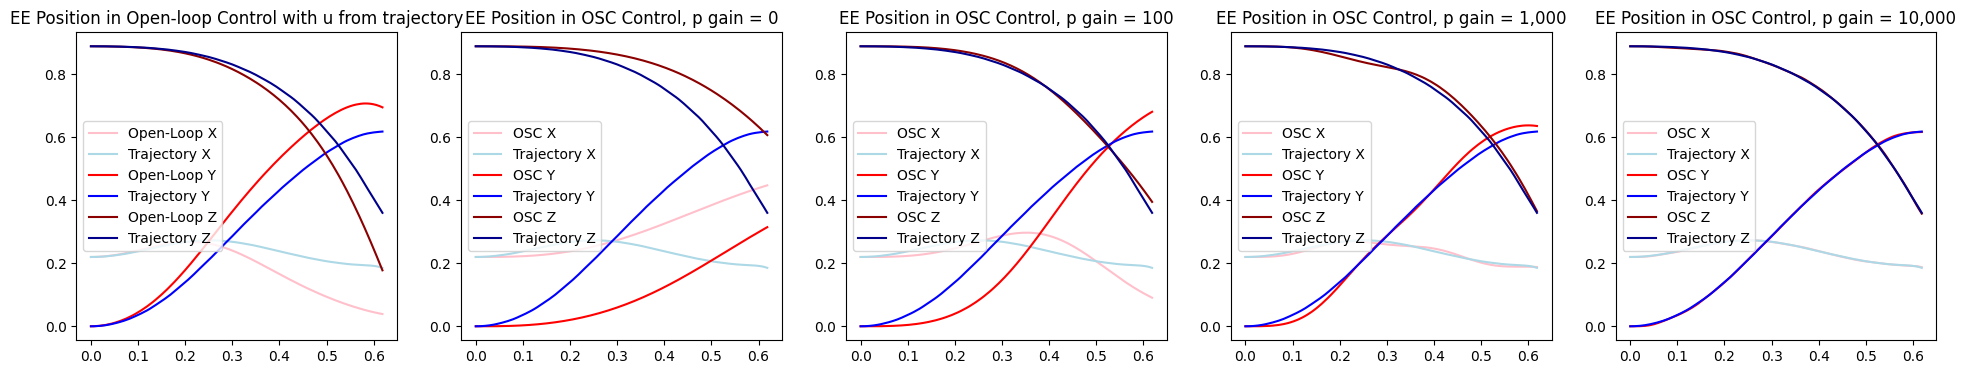

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1154.51it/s]


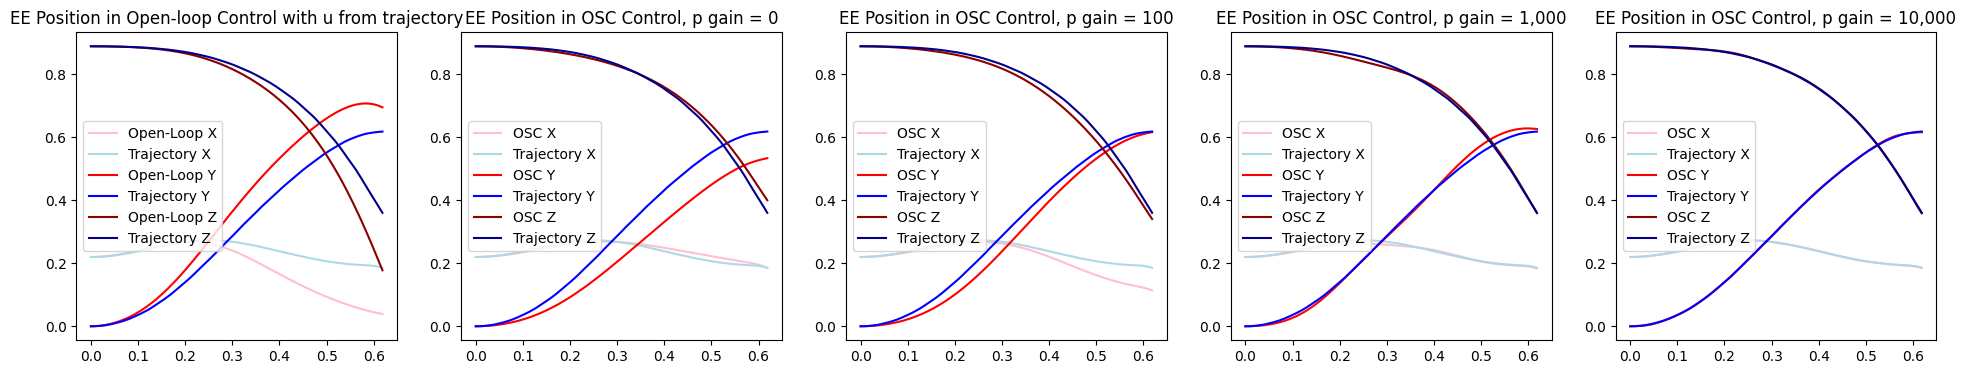

In [108]:
c = lambda plant: ExecuteTraj(plant, u_traj)
t, data = arm_sim(t_catch, initial_state, log=True, control=c)

kD = 5
freq = 100

c = lambda plant: OSC(plant, x_traj, 0, kD, 2, 2, False, freq)
t15, data15 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 100, kD, 2, 2, False, freq)
t2, data2 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 1000, kD, 2, 2, False, freq)
t3, data3 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 10000, kD, 2, 2, False, freq)
t4, data4 = arm_sim(t_catch, initial_state, log=True, control=c)

plt.figure(figsize=(24, 4))
plt.subplot(151)
plt.title('EE Position in Open-loop Control with u from trajectory')
plot_ee(t, data, 'Open-Loop')
plt.subplot(152)
plt.title('EE Position in OSC Control, p gain = 0')
plot_ee(t15, data15, 'OSC')
plt.subplot(153)
plt.title('EE Position in OSC Control, p gain = 100')
plot_ee(t2, data2, 'OSC')
plt.subplot(154)
plt.title('EE Position in OSC Control, p gain = 1,000')
plot_ee(t3, data3, 'OSC')
plt.subplot(155)
plt.title('EE Position in OSC Control, p gain = 10,000')
plot_ee(t4, data4, 'OSC')
plt.show()

c = lambda plant: ExecuteTraj(plant, u_traj)
t, data = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 0, kD, 2, 2, True, freq)
t15, data15 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 100, kD, 2, 2, True, freq)
t2, data2 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 1000, kD, 2, 2, True, freq)
t3, data3 = arm_sim(t_catch, initial_state, log=True, control=c)

c = lambda plant: OSC(plant, x_traj, 10000, kD, 2, 2, True, freq)
t4, data4 = arm_sim(t_catch, initial_state, log=True, control=c)

plt.figure(figsize=(24, 4))
plt.subplot(151)
plt.title('EE Position in Open-loop Control with u from trajectory')
plot_ee(t, data, 'Open-Loop')
plt.subplot(152)
plt.title('EE Position in OSC Control, p gain = 0')
plot_ee(t15, data15, 'OSC')
plt.subplot(153)
plt.title('EE Position in OSC Control, p gain = 100')
plot_ee(t2, data2, 'OSC')
plt.subplot(154)
plt.title('EE Position in OSC Control, p gain = 1,000')
plot_ee(t3, data3, 'OSC')
plt.subplot(155)
plt.title('EE Position in OSC Control, p gain = 10,000')
plot_ee(t4, data4, 'OSC')
plt.show()

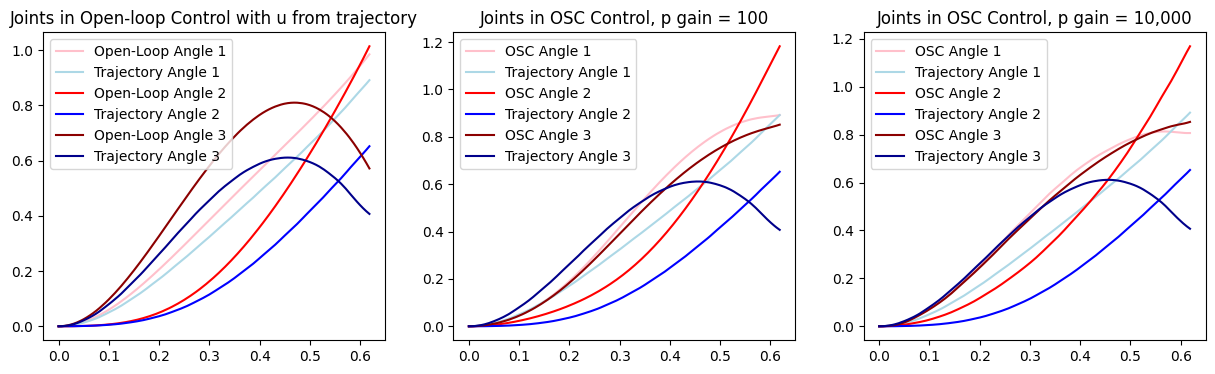

In [110]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title('Joints in Open-loop Control with u from trajectory')
plot_joints(t, data, 'Open-Loop')
plt.subplot(132)
plt.title('Joints in OSC Control, p gain = 100')
plot_joints(t2, data2, 'OSC')
plt.subplot(133)
plt.title('Joints in OSC Control, p gain = 10,000')
plot_joints(t4, data4, 'OSC')

In [111]:
def create_ee_query_angle():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
    Parser(plant).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
    plant.Finalize()
    context = plant.CreateDefaultContext()
    ee_bod = plant.GetBodyByName("panda_link8")
    def query(state):
        context.SetContinuousState(state)
        return plant.EvalBodyPoseInWorld(context, ee_bod).rotation().ToQuaternion()
    return query
    
def plot_ee_angle(t, data, label):
    query = create_ee_query_angle()
    ee_pos = np.array([query(x).wxyz() for x in data.T])
    ee_des_pos = np.array([query(x_traj.value(i)).wxyz() for i in t])
    color = ['pink', 'red', 'darkred', 'black']
    color_des = ['lightblue', 'blue', 'darkblue', 'grey']
    for i,c in enumerate('WXYZ'):
        plt.plot(t, ee_pos[:,i], label=f'{label} {c}', color=color[i])
        plt.plot(t, ee_des_pos[:,i], label=f'Trajectory {c}', color=color_des[i])
    plt.legend()

def plot_ee_angle_err(t, data, label):
    query = create_ee_query_angle()
    errors = []
    for i, x in zip(t, data.T):
        # https://math.stackexchange.com/questions/90081/quaternion-distance
        inner_prod = query(x).wxyz().dot(query(x_traj.value(i)).wxyz())
        errors.append(np.arccos(2*inner_prod**2 - 1) * 180 / np.pi)
    plt.plot(t, errors, label=f'Angular Error')
    plt.ylabel('Error (degrees)')
    plt.legend()

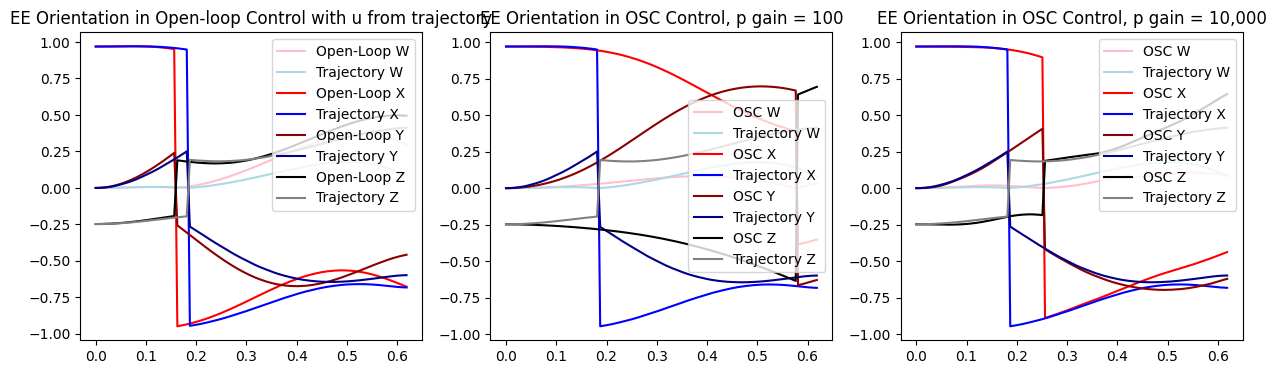

In [112]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title('EE Orientation in Open-loop Control with u from trajectory')
plot_ee_angle(t, data, 'Open-Loop')
plt.subplot(132)
plt.title('EE Orientation in OSC Control, p gain = 100')
plot_ee_angle(t2, data2, 'OSC')
plt.subplot(133)
plt.title('EE Orientation in OSC Control, p gain = 10,000')
plot_ee_angle(t4, data4, 'OSC')
plt.show()

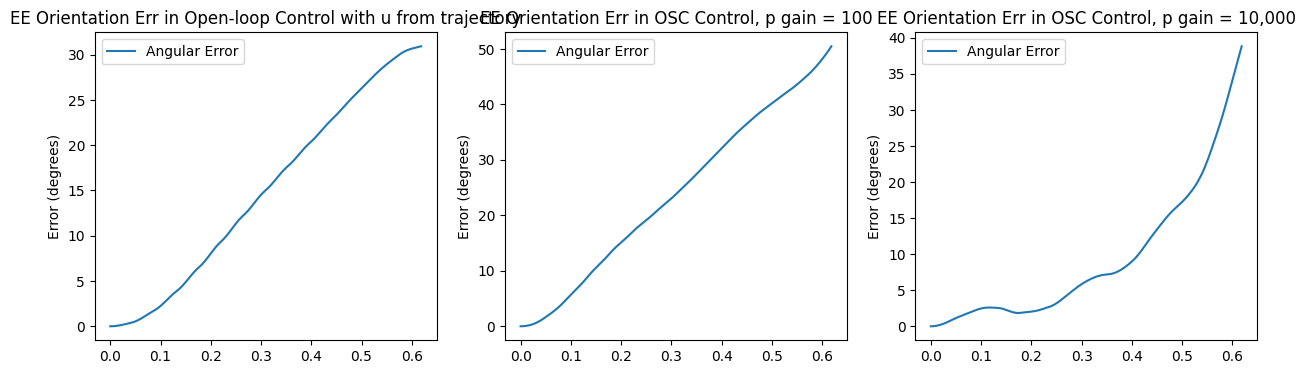

In [113]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title('EE Orientation Err in Open-loop Control with u from trajectory')
plot_ee_angle_err(t, data, 'Open-Loop')
plt.subplot(132)
plt.title('EE Orientation Err in OSC Control, p gain = 100')
plot_ee_angle_err(t2, data2, 'OSC')
plt.subplot(133)
plt.title('EE Orientation Err in OSC Control, p gain = 10,000')
plot_ee_angle_err(t4, data4, 'OSC')
plt.show()